### Importing all the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from time import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer, mean_squared_error
from math import sqrt
import itertools

pd.set_option('display.max.columns', None)

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the data and prepare it for cleaning

In [3]:
data = pd.read_csv('Home_Loan/application_train.csv.tar.gz')

In [4]:
data.shape

(307512, 122)

In [5]:
y = data.iloc[:,1:2]
X = data.drop('TARGET', axis=1)

In [6]:
X.shape

(307512, 121)

In [7]:
# Splitting the data 
RSEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = RSEED)

### Cleaning function from EDA to model training

In [8]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

def clean_data(X, y, test=True):
    global mm_scaler, std_scaler
    
    df = pd.concat([X, y], axis=1)
    
    # Drop rows where target value is missing
    df.dropna(subset=["TARGET"], inplace=True)
    
    # Drop rows where important monetary values are missing
    df.dropna(subset=["AMT_INCOME_TOTAL", "AMT_CREDIT",
                      "AMT_ANNUITY", "AMT_GOODS_PRICE"],
              inplace=True)
    
    # Drop outliers
    if not test:
        idx = np.all(stats.zscore(df[["AMT_INCOME_TOTAL", "AMT_CREDIT",
                                      "AMT_ANNUITY", "AMT_GOODS_PRICE"]]) < 3, axis=1)
        df = df[idx]
    
    # Drop outlier from "DAYS_EMPLOYED" and the "SOCIAL_CIRCLE" columns
    df.drop(index=df[df["DAYS_EMPLOYED"] >= 50000].index, inplace=True)
    df.drop(index=df[df["OBS_30_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["DEF_30_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["OBS_60_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["DEF_60_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    
    # Create list y with target values
    y = df["TARGET"].astype("int").astype("category")
    
    # Create DataFrame X for all features
    X = pd.DataFrame()
    
    # Copy already correct columns
    X["REGION_POPULATION_RELATIVE"] = df["REGION_POPULATION_RELATIVE"]
    
    # Convert data types
    X["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].replace(["Y", "N"], [1, 0]).astype("int")
    X["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].replace(["Y", "N"], [1, 0]).astype("int")
    X["REG_REGION_NOT_LIVE_REGION"] = df["REG_REGION_NOT_LIVE_REGION"].astype("int")
    X["REG_REGION_NOT_WORK_REGION"] = df["REG_REGION_NOT_WORK_REGION"].astype("int")
    X["LIVE_REGION_NOT_WORK_REGION"] = df["LIVE_REGION_NOT_WORK_REGION"].astype("int")
    X["REG_CITY_NOT_LIVE_CITY"] = df["REG_CITY_NOT_LIVE_CITY"].astype("int")
    X["REG_CITY_NOT_WORK_CITY"] = df["REG_CITY_NOT_WORK_CITY"].astype("int")
    X["FLAG_DOCUMENT_2"] = df["FLAG_DOCUMENT_2"].astype("int")
    X["FLAG_DOCUMENT_3"] = df["FLAG_DOCUMENT_3"].astype("int")
    X["FLAG_DOCUMENT_4"] = df["FLAG_DOCUMENT_4"].astype("int")
    X["FLAG_DOCUMENT_5"] = df["FLAG_DOCUMENT_5"].astype("int")
    X["FLAG_DOCUMENT_6"] = df["FLAG_DOCUMENT_6"].astype("int")
    X["FLAG_DOCUMENT_7"] = df["FLAG_DOCUMENT_7"].astype("int")
    X["FLAG_DOCUMENT_8"] = df["FLAG_DOCUMENT_8"].astype("int")
    X["FLAG_DOCUMENT_9"] = df["FLAG_DOCUMENT_9"].astype("int")
    X["FLAG_DOCUMENT_10"] = df["FLAG_DOCUMENT_10"].astype("int")
    X["FLAG_DOCUMENT_11"] = df["FLAG_DOCUMENT_11"].astype("int")
    X["FLAG_DOCUMENT_12"] = df["FLAG_DOCUMENT_12"].astype("int")
    X["FLAG_DOCUMENT_13"] = df["FLAG_DOCUMENT_13"].astype("int")
    X["FLAG_DOCUMENT_14"] = df["FLAG_DOCUMENT_14"].astype("int")
    X["FLAG_DOCUMENT_15"] = df["FLAG_DOCUMENT_15"].astype("int")
    X["FLAG_DOCUMENT_16"] = df["FLAG_DOCUMENT_16"].astype("int")
    X["FLAG_DOCUMENT_17"] = df["FLAG_DOCUMENT_17"].astype("int")
    X["FLAG_DOCUMENT_18"] = df["FLAG_DOCUMENT_18"].astype("int")
    X["FLAG_DOCUMENT_19"] = df["FLAG_DOCUMENT_19"].astype("int")
    X["FLAG_DOCUMENT_20"] = df["FLAG_DOCUMENT_20"].astype("int")
    X["FLAG_DOCUMENT_21"] = df["FLAG_DOCUMENT_21"].astype("int")
    
    # Create dummy variables for categorical columns
    X = pd.concat([X, pd.get_dummies(df[["NAME_CONTRACT_TYPE", "CODE_GENDER", "NAME_TYPE_SUITE",
                                         "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
                                         "NAME_HOUSING_TYPE", "ORGANIZATION_TYPE"]],
                                     drop_first=True)],  axis=1)
    
    # Filling all NaNs with mean values
    col_names = df.loc[:, "EXT_SOURCE_1" : "NONLIVINGAREA_MEDI"].columns
    X[col_names] = df[col_names].fillna(value=df[col_names].median())
    X["TOTALAREA_MODE"] = df["TOTALAREA_MODE"].fillna(value=df["TOTALAREA_MODE"].median())
    
    social_circle = ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                     "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
    X[social_circle] = df[social_circle].fillna(value=df[social_circle].median())
    
    enquiries = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY",
                 "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",
                 "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
    X[enquiries] = df[enquiries].fillna(value=df[enquiries].median())    
    
    # Making time span variables positive
    timespanes = ["DAYS_BIRTH", "DAYS_EMPLOYED",
                 "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
    X[timespanes] = df[timespanes] * -1
    
    # Use Scaler
    std_scaled = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY",
                  "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]
    X["CNT_CHILDREN"] = df["CNT_CHILDREN"]
    mm_scaled = ["CNT_CHILDREN", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION",
                 "DAYS_ID_PUBLISH", "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                 "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_HOUR",
                 "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",
                 "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
        
    if test:
        X[std_scaled] = std_scaler.transform(df[std_scaled])
        X[mm_scaled] = mm_scaler.transform(X[mm_scaled])
    else:
        X[std_scaled] = std_scaler.fit_transform(df[std_scaled])
        X[mm_scaled] = mm_scaler.fit_transform(X[mm_scaled])
    
    return X, y

### Cleaning the train and test data sets

In [9]:
# Preparing X and y train data for balancing
X_train_clean, y_train_clean = clean_data(X_train, y_train, test=False)

In [10]:
# Cleaning test data set for prediction purpose
X_test_clean, y_test_clean = clean_data(X_test, y_test, test=True)

### Undersampling to deal with imbalanced cleaned training data

In [11]:
# Define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=RSEED)

# Fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train_clean, y_train_clean)

### Defining a function to train, predict and plot 

In [12]:
# Function for model training

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size] ,y_train[:sample_size])
    end = time() # Get end time
      
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    # then get predictions on the first 1000 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    predictions_test_prob = learner.predict_proba(X_test)[:,1]
    predictions_train_prob = learner.predict_proba(X_train)[:,1]
    end = time() # Get end time
    
    '''
    Evaluation through different parameters
    '''
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the train set
    results['acc_train'] = accuracy_score(y_train,predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the train set
    results['f_beta_train'] = fbeta_score(y_train ,predictions_train,beta=2)
        
    # Compute F_beta-score on the test set
    results['f_beta_test'] = fbeta_score(y_test,predictions_test,beta=2)
    
    # Compute Precision_score on the train set
    results['Precision_train'] = precision_score(y_train, predictions_train)
    
    # Compute Precision_score on the test set
    results['Precision_test'] = precision_score(y_test, predictions_test)
    
    # Compute Recall_score on the train set
    results['Recall_train'] = recall_score(y_train ,predictions_train)
    
    # Compute Recall_score on the test set
    results['Recall_test'] = recall_score(y_test, predictions_test)
    
    # Compute roc_auc_score on the train set
    results['Roc_Auc_Score_train'] = roc_auc_score(y_train ,predictions_train)
    
    # Compute roc_auc_score on the train set
    results['Roc_Auc_Score_test'] = roc_auc_score(y_test, predictions_test)
    
    # Compute f1_score on the train set
    results['F1_score_train'] = f1_score(y_train ,predictions_train)
    
    # Compute f1_score on the test set
    results['F1_score_test'] = f1_score(y_test ,predictions_test)
    
    # Compute RMSE on the train set
    results['RMSE_train'] = sqrt(mean_squared_error(y_train ,predictions_train))
    
    
    # Compute RMSE on the test set
    results['RMSE_test'] = sqrt(mean_squared_error(y_test ,predictions_test))
    
    
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("*" *100)
    print()
    
    '''
    Evaluation through confusion matrix and ROC_CURVE plot
    '''
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predictions_test)
    
    # Plotting the confusion matrix
    disp = plot_confusion_matrix(learner, X_test, y_test,
                             display_labels=['non-defaulter', 'defaulter'],
                             cmap=plt.cm.OrRd, 
                             normalize=None,
                             values_format = 'd')

    plt.grid(False)
    plt.show()
    print()
    print()
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _   = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, predictions_test_prob)
    
    # Plotting the ROC_curve:
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    lw = 4
    plt.plot(base_fpr, base_tpr, '#5e6e8a', label = 'baseline', lw=lw)
    plt.plot(model_fpr, model_tpr, '#e37e5f', label = 'model',lw=lw)
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
    
    # Return the results
    return results

### Defining basic models and plotting the results

LogisticRegression trained on 30116 samples.
****************************************************************************************************



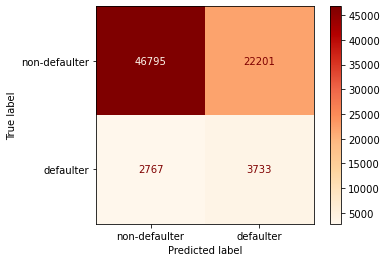

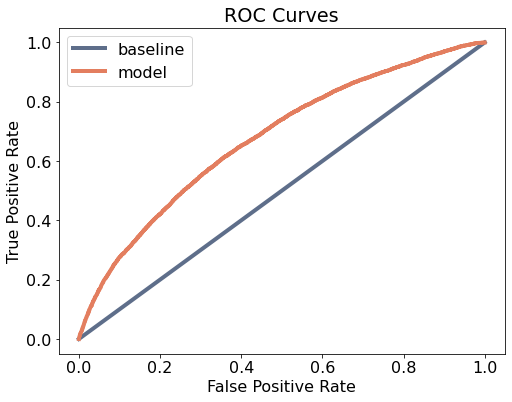

DecisionTreeClassifier trained on 30116 samples.
****************************************************************************************************



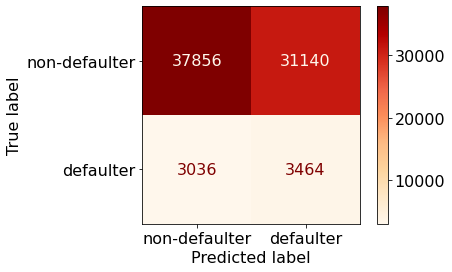

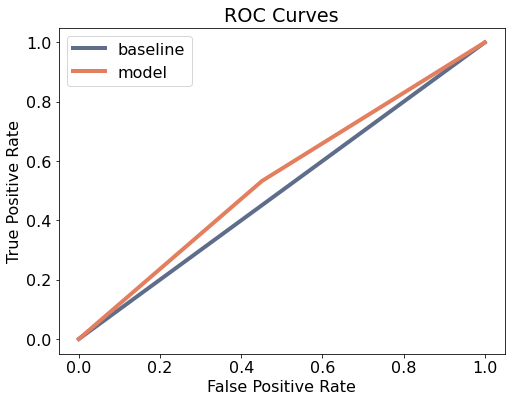

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 out of 196 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 196 out of 196 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 196 out of 196 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

RandomForestClassifier trained on 30116 samples.
****************************************************************************************************



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 196 out of 196 | elapsed:    0.2s finished


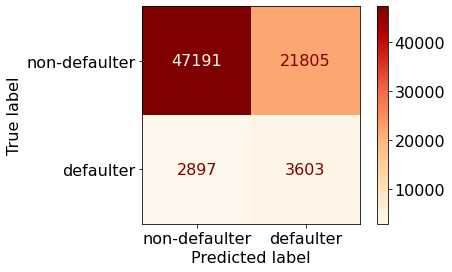

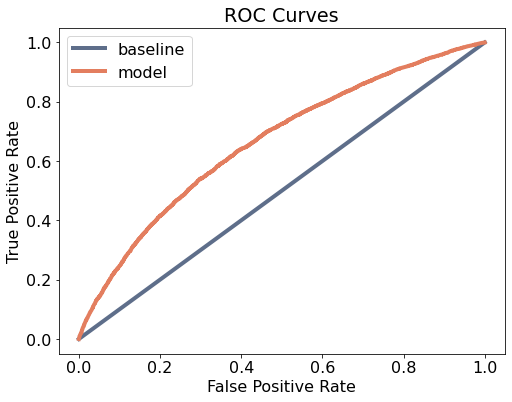

XGBClassifier trained on 30116 samples.
****************************************************************************************************



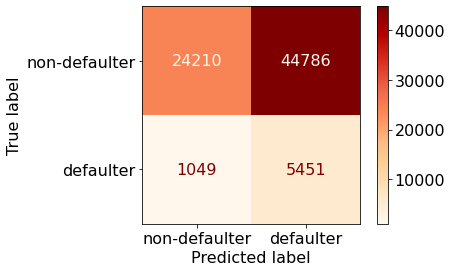

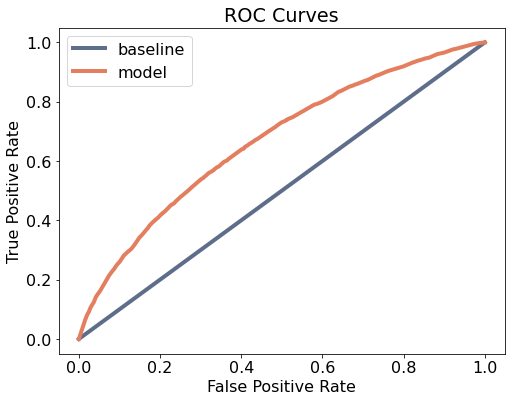

In [13]:
# Initialize the three models, the random states are set to constant RSEED so we know how to reproduce the model later
clf_A = LogisticRegression(random_state=RSEED)

clf_B = DecisionTreeClassifier(random_state=RSEED)

clf_C = RandomForestClassifier(n_estimators=196, min_samples_split = 2, 
                               max_leaf_nodes = 49, max_depth = 17, 
                               bootstrap = True, max_features = 'auto', 
                               min_weight_fraction_leaf = 0.1,  
                               n_jobs=-1, verbose = 1, random_state=RSEED)

clf_D = XGBClassifier(n_estimators = 200, gamma = 100, 
                      learning_rate = 0.01, max_depth = 12, booster = 'gbtree',
                      scale_pos_weight = 1.5, objective='binary:logistic')

# Length of Training data stored in a variable as sample size
samples = len(X_train_under)

# Considering only the most important features from EDA to build prediction models
imp_features = [
                'REGION_POPULATION_RELATIVE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
                'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 
                'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
                'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 
                'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 
                'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
                'FLAG_DOCUMENT_10', 'NAME_FAMILY_STATUS_Married', 
                'EXT_SOURCE_2', 'DAYS_BIRTH'
                ]

# Collect results on the learners
results = {}

for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = \
    train_predict(clf, samples, X_train_under[imp_features], 
                  y_train_under, X_test_clean[imp_features], y_test_clean)

### Displaying all result parameters for each model

In [14]:
# Displaying the results of predictions
for i in results.items():
    print (i[0])
    display(pd.DataFrame.from_dict(i[1], orient='index').rename(columns={0:'100 % Data'}))

LogisticRegression


,100 % Data
train_time,0.217844
pred_time,0.020865
acc_train,0.622991
acc_test,0.669280
f_beta_train,0.587634
f_beta_test,0.359398
Precision_train,0.635519
Precision_test,0.143942
Recall_train,0.576770
Recall_test,0.574308


DecisionTreeClassifier


,100 % Data
train_time,0.199027
pred_time,0.073702
acc_train,1.000000
acc_test,0.547314
f_beta_train,1.000000
f_beta_test,0.285790
Precision_train,1.000000
Precision_test,0.100104
Recall_train,1.000000
Recall_test,0.532923


RandomForestClassifier


,100 % Data
train_time,0.678153
pred_time,0.574653
acc_train,0.617379
acc_test,0.672804
f_beta_train,0.575275
f_beta_test,0.350432
Precision_train,0.631795
Precision_test,0.141806
Recall_train,0.562691
Recall_test,0.554308


XGBClassifier


,100 % Data
train_time,8.000872
pred_time,0.347845
acc_train,0.585470
acc_test,0.392882
f_beta_train,0.759875
f_beta_test,0.357504
Precision_train,0.556937
Precision_test,0.108506
Recall_train,0.836034
Recall_test,0.838615


### Randomforest model with RandomSearchCV

In [15]:
# Creating a valid argument for scoring parameter in RandomSearchCV
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [16]:
# Hyperparameter tuning
param_grid = {
             'n_estimators': np.linspace(10, 200).astype(int),
             'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
             'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
             'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
             'min_samples_split': [2, 5, 10],
             'bootstrap': [True, False]
             }

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = ftwo_scorer, cv = 5, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

In [27]:
# Getting best parameter by fitting the model 
rs.fit(X_train_under[imp_features], y_train_under)
rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   48.5s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.8s finished


{'n_estimators': 91,
 'min_samples_split': 10,
 'max_leaf_nodes': 19,
 'max_features': 0.6,
 'max_depth': 5,
 'bootstrap': False}

### Using the best model estimator for the prediction 

In [28]:
# Getting the best estimator 
best_model = rs.best_estimator_

In [30]:
# Predicting using the best estimator
train_rf_predictions = best_model.predict(X_train_under[imp_features])
train_rf_probs = best_model.predict_proba(X_train_under[imp_features])[:, 1]

test_rf_predictions = best_model.predict(X_test_clean[imp_features])
test_rf_probs = best_model.predict_proba(X_test_clean[imp_features])[:, 1]

In [31]:
# Printing the result summary of Best model performance
print(classification_report(y_test_clean, test_rf_predictions))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     68996
           1       0.14      0.60      0.22      6500

    accuracy                           0.64     75496
   macro avg       0.54      0.62      0.50     75496
weighted avg       0.88      0.64      0.72     75496



In [32]:
# Evaluating and plotting through confusion matrix
print(confusion_matrix(y_test_clean, test_rf_predictions))

[[44693 24303]
 [ 2611  3889]]


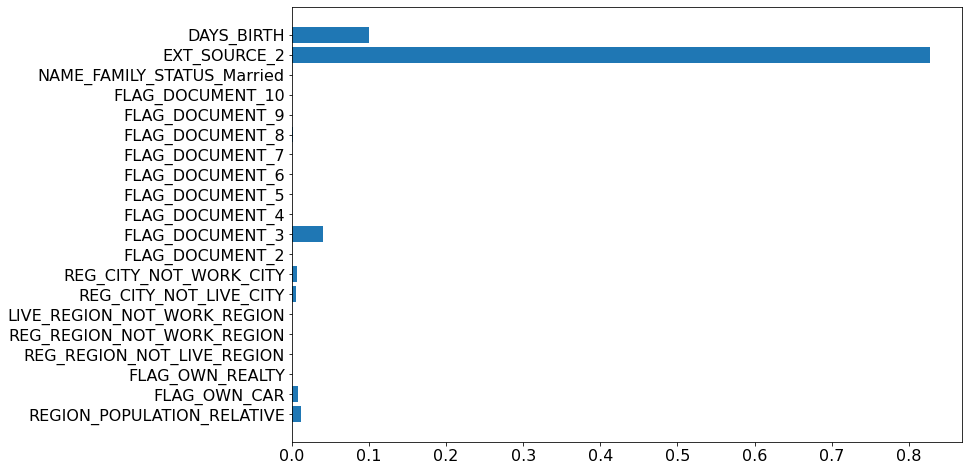

In [36]:
plt.figure(figsize=(12,8))
plt.barh(imp_features, best_model.feature_importances_)
plt.show();

### Randomforest model with GridSearchCV

In [37]:
# Hyperparameter tuning
param_grid = { 
            'n_estimators': [10, 18, 22, 50, 100, 200],
            'max_depth': [3, 5, 12],
            'max_features': ["auto", "sqrt", "log2"],
            'max_leaf_nodes': [5, 10, 20],
            'min_samples_split': [2, 5, 10, 15, 20],
            'bootstrap': [True, False], 
            "min_weight_fraction_leaf": [0.1]
            }

# Estimator for use in Grid search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the Grid search model
gs = GridSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 5, 
                        verbose = 5)

### Using the best model estimator for the prediction 

In [38]:
# Getting the best parameter by fitting the model
gs.fit(X_train_under[imp_features], y_train_under)
gs.best_params_

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 100}

In [39]:
# Getting the best estimator 
best_model = gs.best_estimator_

In [41]:
# Predicting using the best estimator model
train_rf_predictions = best_model.predict(X_train_under[imp_features])
train_rf_probs = best_model.predict_proba(X_train_under[imp_features])[:, 1]

test_rf_predictions = best_model.predict(X_test_clean[imp_features])
test_rf_probs = best_model.predict_proba(X_test_clean[imp_features])[:, 1]

In [42]:
# Printing the result summary of Best model performance
print(classification_report(y_test_clean, test_rf_predictions))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     68996
           1       0.14      0.56      0.23      6500

    accuracy                           0.67     75496
   macro avg       0.54      0.62      0.51     75496
weighted avg       0.87      0.67      0.74     75496



In [43]:
# Evaluating and plotting through confusion matrix
print(confusion_matrix(y_test_clean, test_rf_predictions))

[[46710 22286]
 [ 2851  3649]]
